## I) Introduction


This program can be used to create linkage graphs based on selected Wikipedia articles. Please read the description in chapter **I) Introduction** completely before you start running the program in the Jupyter Notebook.

**The program consists of three sections:**
- Section *I) Introduction* provides a brief overview of the program and its use. 
- Section *II) Program* contains the programming implementation. This in turn is divided into the import of the required libraries, the definition of the sub-methods and the execution of the main method. 
- Within section *III) Program execution* the user chooses the relevant login-data, Wikipedia categories, the project name and the graph type to be created and executes the main method.


**Process description:**
> First, all lines of code in chapter "II Program" must be executed. After that in chapter "III) Program execution" the login data for an account for https://de.wikipedia.org/ has to be provided. If you don't have an account yet, please create one.

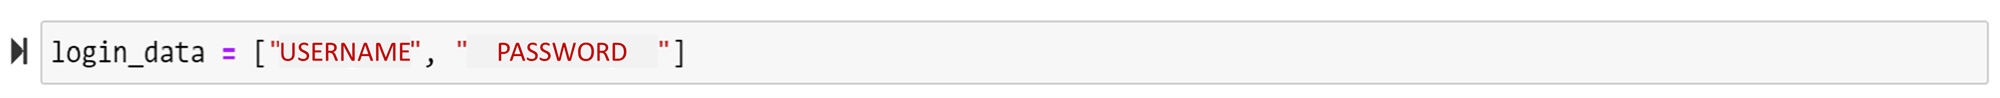

> Subsequently one or more Wikipedia categories have to be provided as input.

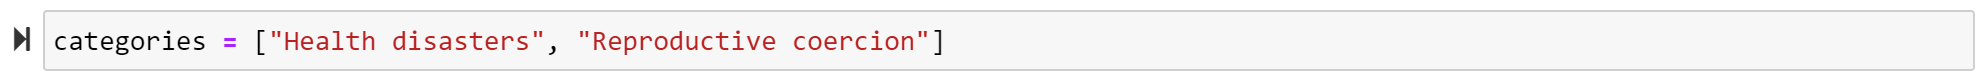

> A project name has to be selected.

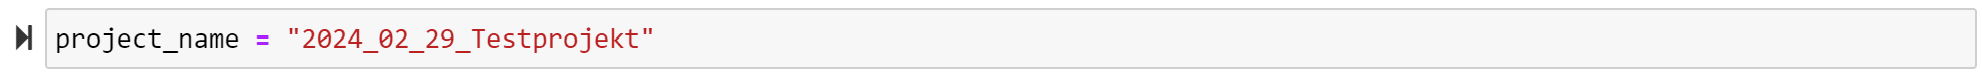

> The type of linkage graph have to be selected. The following three types of graphs are available:

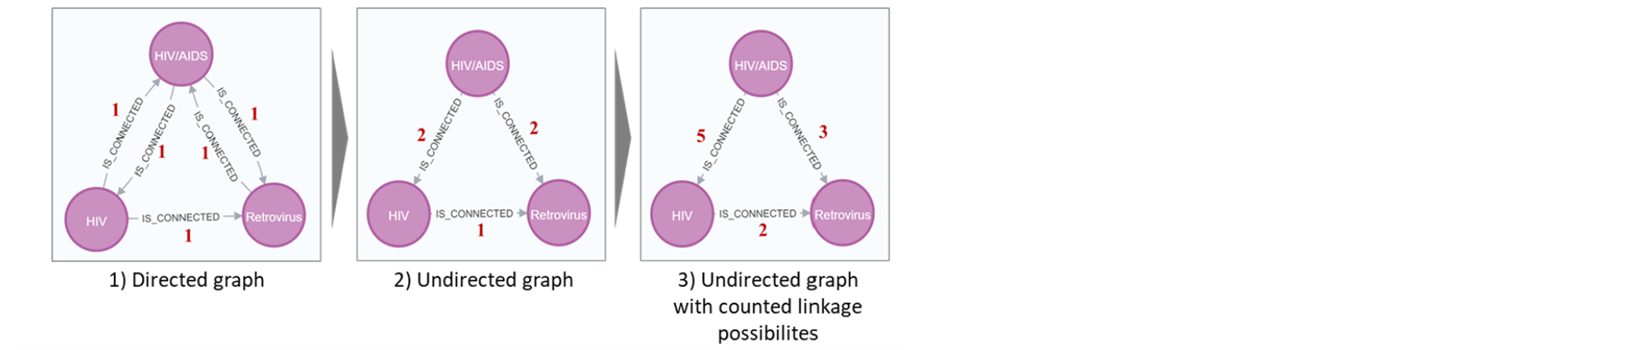

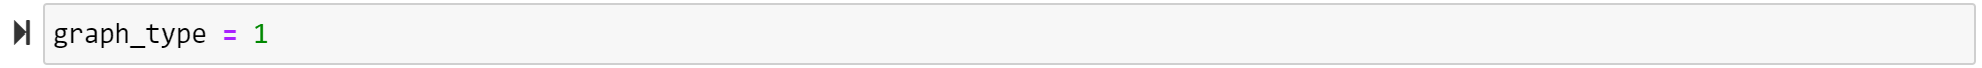

> After inserting the project name and the graph type into the respective command, the method call is executed:

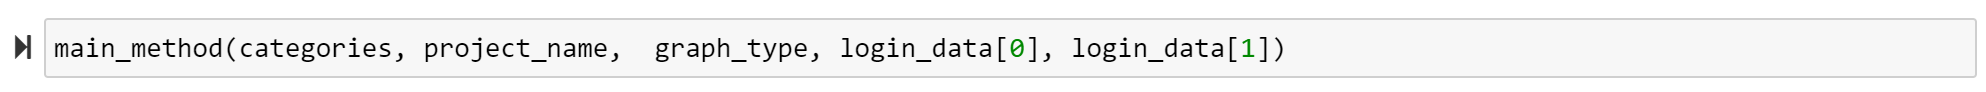

> Executing the method creates the project folder in the user's personal directory (C/User/Username/...):

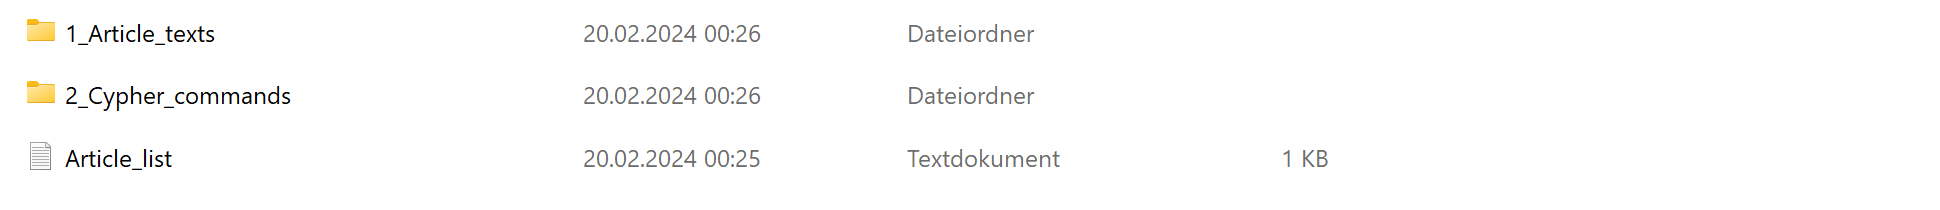

> Within the folder "2_Cypher_commands" the commands to create the graph's nodes and edges have been saved within two textfiles:

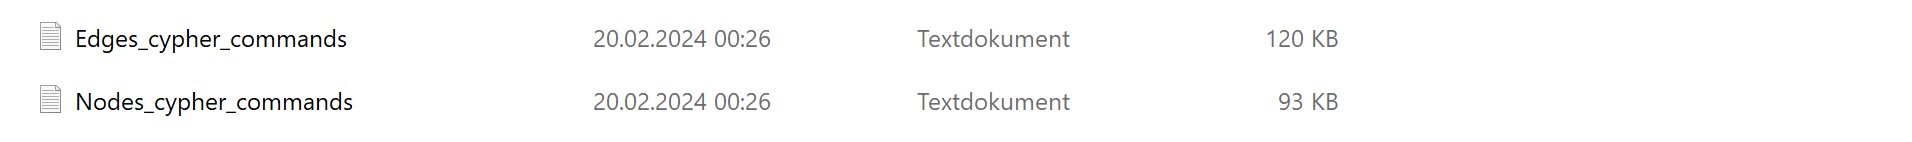

> By copying the content of the "Nodes_cypher_commands" file and the "Edges_cypher_commands" file in the command line in Neo4j and executing it, the linkage graph is imported into the graph database

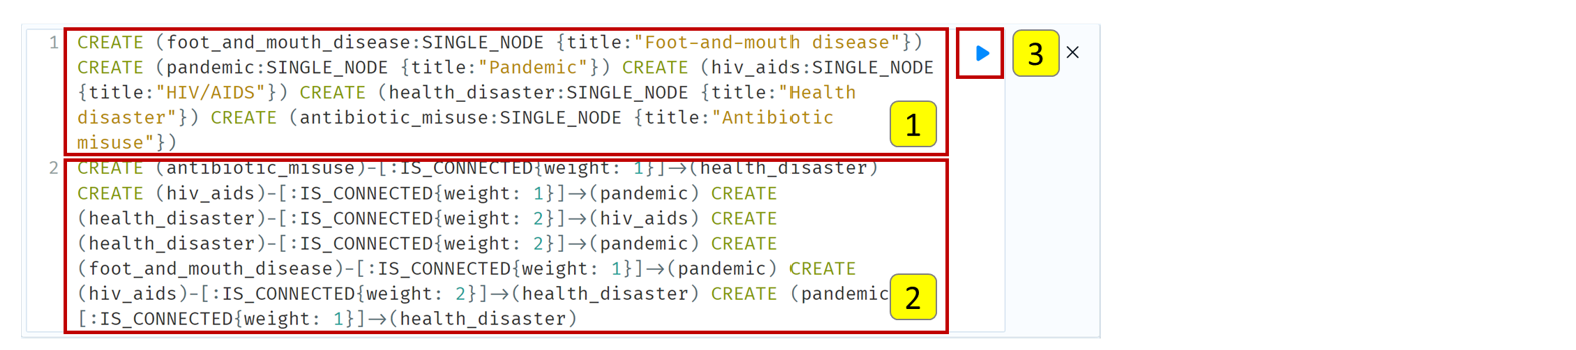

> After execution is finished, the graph is generated in Neo4j - the execution can take several minutes depending on the amount of data:

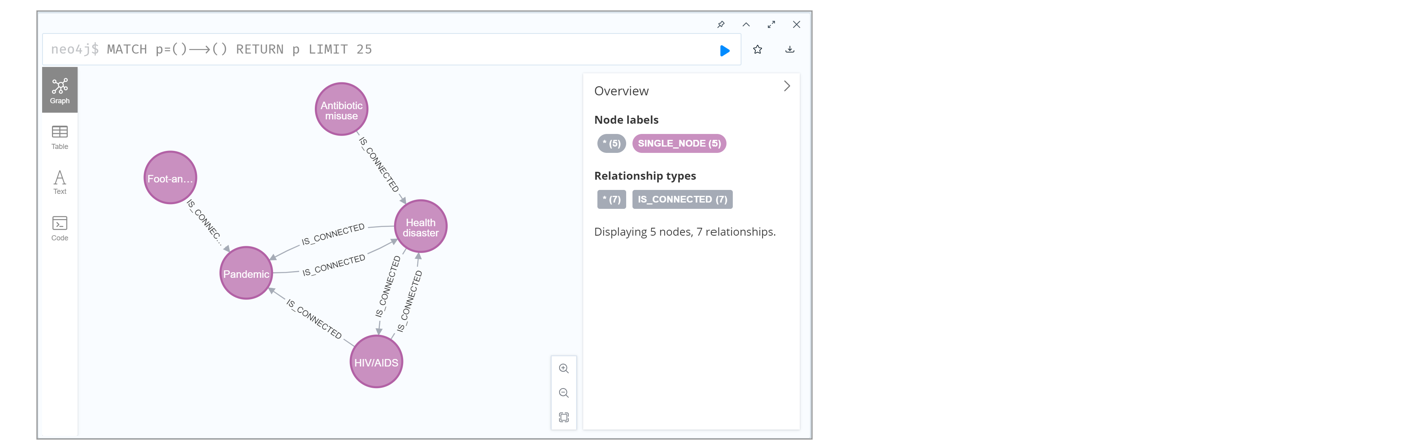

> Once the relevant linkage graph has been generated, it can be analyzed in the graph database.

## II) Program

#### 1) Library import

In [1]:
import requests
import csv
import re
import os
from json import dumps

#### 2) Method definition

Creation of overview with relevant articles

In [2]:
def get_articles_by_category(category):
    # Returns a list of wikipedia articles for a selected category or subcategory
    
    # params: Category as string
    # returns: Articles within the category
    # rtype: List
    
    url = f"https://en.wikipedia.org/w/api.php?action=query&format=json&list=categorymembers&cmtitle=Category:{category}&cmlimit=500"
    response = requests.get(url)
    data = response.json()
    
    articles = {}
    
    if 'query' in data and 'categorymembers' in data['query']:
        for member in data['query']['categorymembers']:
            if member['ns'] == 0:
                articles[member['title']] = category
    
    return articles

In [3]:
def get_keys(dictionary):
    # Returning the keys of a dictionary as a list
    
    # params: Input dictionary
    # returns: Keys within the dictionary
    # rtype: List
    
    return list(dictionary.keys())

In [4]:
def create_article_list_with_given_selection(category_list):
    # Creation of a list with unique titles for articles within the given categories
    
    # params: Input list of categories
    # returns: Output list of articles
    # rtype: List
    
    article_dict = {}
    
    for cat in category_list:
        article_dict.update(get_articles_by_category(cat))
    
    article_list = []
    article_list = get_keys(article_dict)
    
    print("- Based on the specified categories a data set of " + str(len(article_list)) + " articles has been generated")
    
    return article_list

In [5]:
def save_article_list(article_list, project_name):
    # Saving relevant article titles within a defined project folder within the user directiory
    
    # params: Relevant articles as list, name of the project folder as string
    # returns: Project folder with article list in format ".txt"
    # rtype: -
    
    
    # Generate project path and folder
    user_path = os.path.expanduser('~')
    path = os.path.join(user_path, project_name)
    
    # Check if folder exists - if not create new folder
    if not os.path.exists(path):
        os.makedirs(path)
    
    full_path = path + "\Article_list.txt"

    # Save article list as ".txt" within target folder
    with open(full_path, 'w', newline='', encoding='utf-8') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(article_list)

Acces and storage of relevant article texts

In [6]:
def get_article_text(title, username, password):
    # Access of MediaWiki API and query of the relevant article text
    
    # params: Article title as string
    # returns: Query response
    # rtype: Dictionary
    
    # Access MediaWiki API
    session = requests.Session()
    url = "https://en.wikipedia.org/w/api.php"
    
    params_0 = {
    'action':"query",
    'meta':"tokens",
    'type':"login",
    'format':"json"
    }
    
    req = session.get(url=url, params= params_0)
    data = req.json()
    
    login_token = data['query']['tokens']['logintoken']
    
    # Choose login parameters
    params_1 = {
    'action': "login",
    'lgname': username, 
    'lgpassword': password,
    'lgtoken': login_token,
    'format': "json"
    }
    req = session.post(url, data=params_1)
    data = req.json()
    
    # Get article text
    content_params = {
        "action": "query",
        "prop": "revisions",
        "titles": title,
        "rvprop": "content",
        "format": "json"
    }
    
    content_response = session.get(url, params=content_params).json()

    return content_response

In [7]:
def convert_tostring(dictionary):
    # Extraction of article text form query response and convertion to string
    
    # params: API query as dictionary
    # returns: Article text
    # rtype: String
    
    reduced_dictionary = dictionary['query']
    convert = dumps(reduced_dictionary)
    return convert

In [8]:
def extract_text_and_save_data(article_list, project_name, username, password):
    # Storing article texts within a defined project folder within the user directiory
    
    # params: Relevant articles as list, name of the project folder as string
    # returns: Folder with article texts in format ".txt", Error-Message in case of problem
    # rtype: Message
    
    # Initialize counter variable
    counter = 0
    
    # Generate project path and folder
    user_path = os.path.expanduser('~')
    path = os.path.join(user_path, project_name)
    full_path = path + "\\1_Article_texts"
        
    # Check if folder exists - if not create new folder
    if not os.path.exists(full_path):
        os.makedirs(full_path)
    
    for article in article_list:
        content = get_article_text(article, username, password)
        content_str = convert_tostring(content)
        data_name = article  
        
        # Check if article title contains "/" - if so replace it with "_"
        if "/" in data_name:
            data_name = data_name.replace("/", "_")
        
        # Check if article title contains "," - if so replace it with "_"
        if "," in data_name:
            data_name = data_name.replace(",", "_")
       
        # Save article text as ".txt" within target folder
        try:
            data_path = full_path + '/' + data_name + ".txt"
            with open(data_path, 'w', encoding='utf-8') as data:
                data.write(content_str)
            
            # Increase counter variable
            counter += 1
            
        except IOError:
            print("-- Error occurred while writing data: " + data_name)
            
    print("- " + str(counter) + " article texts have successfully been accessed and saved within a file")

In [9]:
def read_article_text(file_name, folder_path):
    # Extraction of article text from text file within project folder 
    
    # params: File name as string
    # returns: Text within file
    # rtype: String
    
    # Check if article title contains "/" - if so replace it with "_"
    if "/" in file_name:
        file_name = file_name.replace("/", "_")
        
    # Check if article title contains "," - if so replace it with "_"
    if "," in file_name:
        file_name = file_name.replace(",", "_")
    
    # Define file path incl. ending .txt
    file_path = os.path.join(folder_path, file_name)
    file_path += ".txt"

    if os.path.isfile(file_path):
        with open(file_path, 'r') as file:
            content = file.read()
        return content
    else:
        print(f"The file '{file_name}' hasn't been found within '{folder_path}'.")
        return ""

Clean article texts

In [10]:
def remove_references(string):
    # Deleting references, appendix, etc. from article text
    
    # params: Text as string
    # returns: Text
    # rtype: String
    
    # Define patterns to be removed within string
    pattern_one = r"<ref>.*?</ref>"
    pattern_two = r"<ref name=.*?</ref>"
    pattern_three = r"File:.*?.jpg"
    pattern_four = r"Category:.*?"
    pattern_five = r"\\.*?"
    pattern_six = r"Help:List.*?"
    pattern_seven = r"wikt:.*?"
    
    # Order and application of patterns
    red_string = re.sub(pattern_two, "", 
                        re.sub(pattern_one, "", 
                               re.sub(pattern_three, "", 
                                      re.sub(pattern_four, "", 
                                            re.sub(pattern_five, "", 
                                                   re.sub(pattern_six, "", 
                                                         re.sub(pattern_seven, "", string)))))))
    
    # Additionally remove reference list
    result = red_string[0:red_string.find("{{Refbegin}}")]
    
    return result

In [11]:
def clean_special_characters(input_string):
    # Cleaning/Replacing undesired combination of characters within the string
    
    # params: Text as string
    # returns: Text
    # rtype: String
    
    # Define the characters and strings to be replaced
    formatted_string = input_string.replace('"\n', '') # relevant to avoid problem with "Twiddler's syndrome"
    formatted_string = formatted_string.replace("\\\\", "")
    formatted_string = formatted_string.replace("u2013", "-")
    formatted_string = formatted_string.replace("u00f6", "ö")
    formatted_string = formatted_string.replace("00fc", "ü")  
    formatted_string = formatted_string.replace("u00e4", "ä")  
    formatted_string = formatted_string.replace("u00fc", "ü")
    formatted_string = formatted_string.replace("u00e9", "é")
    formatted_string = formatted_string.replace("u00e2", "â")
    formatted_string = formatted_string.replace("u00e8", "è")
    formatted_string = formatted_string.replace("u00e0", "à")
    formatted_string = formatted_string.replace("u00f3", "ó")
    formatted_string = formatted_string.replace("u00e1", "á")
    formatted_string = formatted_string.replace("u00f8", "ø")
    formatted_string = formatted_string.replace('"', '')
    
    return formatted_string

Extract links from article text

In [12]:
def remove_exceptions(input_list, exception_list):
    # Removing defined entries from an input list - can be used do remove exception from list
    
    # params: Defined exceptions as  a list
    # returns: List without defined exceptions
    # rtype: List
    
    # Remove entries from list
    output_list = [item for item in input_list if item not in exception_list]
    
    return output_list

In [13]:
def extract_links(string):
    # Extraction of links from article text and returns a list of strings
    
    # params: Article text as string
    # returns: Internal links within the article text
    # rtype: List
    
    result = []
    
    # Links within Wikipedia articles are marked by '[[...]]'
    start = string.find("[[")
    while start != -1:
        end = string.find("]]", start + 1)
        if end == -1:
            break
        
        # Check if it is a masked link
        linked_content = string[start + 2:end]
        
        
        # If masked link - remove second part from string (from '|' on)
        if '|' in linked_content:
            linked_content = linked_content[:linked_content.find("|")]
        
        # If reference to specific chapter - remove second part from string (from '#' on)
        if "#" in linked_content:
            linked_content = linked_content[:linked_content.find("#")]
            
        # If extracted links contains 'ile:' - remove it
        if "ile:" in linked_content:
            linked_content = ""
            
        # If extracted links contains 'mage:' - remove it
        if "mage:" in linked_content:
            linked_content = ""
        
        result.append(linked_content)
        start = string.find("[[", end + 1)
        
        result = remove_exceptions(result, ["n "])
        
    return result

In [14]:
def remove_empty_entries(entry_list):
    # Removal of empty entries from a list and returns a list
    
    # params: Input as list
    # returns: List without empty entries
    # rtype: List
    
    try:
        while True:
            entry_list.remove("")
            
    except ValueError:
        pass
    
    return entry_list

In [15]:
def clean_multiple_entries(entry_list):
    # Cleaning multiple entries within the nodes - a node is unique within the linkage graph
    
    # params: Potential graph nodes as list
    # returns: Nodes without duplicates
    # rtype: List
    
    # Transform list into a set and then back into a list
    unique_list = list(set(entry_list))
    
    return unique_list

Creation of nodes list and cypher commands

In [16]:
def extract_nodes_from_article_list(articles_list, project_name):
    # Extraction of nodes from all articles within the defined article list and folder
    
    # params: List with article titles
    # returns: Unique nodes within all articles
    # rtype: List
    
    nodes = []
    
    # Identify project path and folder
    user_path = os.path.expanduser('~')
    path = os.path.join(user_path, project_name)
    full_path = path + "\\1_Article_texts" + "\\"
    
    # Iterate over article list
    for article in articles_list:
        
        # Add the original article titel -> cleaned
        nodes.append(clean_special_characters(article))
        
        # Read article text from txt file in folder
        article_text = read_article_text(article, full_path)

        # Remove references
        text_without_references = remove_references(article_text)

        # Clean special characters in string
        text_cleaned = clean_special_characters(text_without_references)

        # Extract links from text
        text_links = extract_links(text_cleaned)

        # add extracted links zu nodes list
        nodes.extend(text_links)
    
    # Clean multiple entries -> each node is unique
    nodes_cleaned = clean_multiple_entries(nodes)
    
    # Remove empty entries within list
    nodes_cleaned_without_empty_entries = remove_empty_entries(nodes_cleaned)
    
    # Remove duplicate variable declarations
    nodes_cleaned_no_duplicates = remove_duplicate_variables(nodes_cleaned_without_empty_entries)
    
    # Remove exception: entry 
    
    return nodes_cleaned_no_duplicates

In [17]:
def convert_to_neo4j_variable(string):
    # Convertion of extracted link to neo4j variable
    
    # params: Article tile as string
    # returns: article title as neo4j variable
    # rtype: String
    
    # Replace all characters not admitted for variable name
    cleaned_string = re.sub(r'[^a-zA-Z0-9_]', '_', string)
    
    # If first letter is a digit, add "_"
    if cleaned_string[0].isdigit():
        cleaned_string = '_' + cleaned_string
    
    # Change capital letters wihin variable name
    cleaned_string = cleaned_string.lower() 
    
    return cleaned_string

In [18]:
def remove_duplicate_variables(string_list):
    # Method that removes variables which are not unique within list and returns a list of unique entris
    # -> A link declaration could be "Disease" or "disease" by deriving the same neo4j variable only a single node
    # is created within the linkage graph
    
    string_dict = {}
    
    # Create dict entry with neo4j variable as key and extracted link as value
    for string in string_list:
        key = convert_to_neo4j_variable(string)
        value = string
        
        # Check if key exists already in dict
        if key not in string_dict:
            string_dict[key] = value
    
    unique_values = list(string_dict.values())
    
    return unique_values

In [19]:
def create_nodes_db(nodes_list):
    # Creation of cipher commands to insert nodes into neo4j database from a nodes list and returns a string
    
    # params: Nodes as list
    # returns: Cypher commands to create nodes
    # rtype: List
    
    entries_list = []
    command_part_1 = 'CREATE ('
    command_part_2 = ':SINGLE_NODE {title:"'
    command_part_3 = '"}) '
    
    # Create command for nodes
    for node in nodes_list:
        command_total = command_part_1 + convert_to_neo4j_variable(node) + command_part_2 + node + command_part_3
        entries_list.append(command_total)
     
    # Change list to string
    entries_list_string = ''.join(entries_list)
    
    return entries_list_string

In [20]:
def save_data(data_string, project_name, file_name):         
    # Saving a string as a text file with a defined name
    
    # params: Input as string
    # returns: Output file
    # rtype: txt.-file, message
    
    # Generate project path and folder
    user_path = os.path.expanduser('~')
    path = os.path.join(user_path, project_name)
    full_path = path + "\\2_Cypher_commands"
    
    # Check if folder exists - if not create new folder
    if not os.path.exists(full_path):
        os.makedirs(full_path)
    
    try:
        with open(full_path + "\\" + file_name, 'w') as data:
            data.write(data_string)
        print("--> File '" + file_name + "' has successfully been created")
        
    except IOError:
        print("Error occurred whlile trying to create file " + file_name)

Creation of edges list, weights and cypher commands for directed graph

In [21]:
def extract_directed_edges_from_article_list(articles_list, project_name):
    # Extraction of all edges from all articles within the article selection and folder
    
    # params: List with article titles, project name as string
    # returns: Unqique edges (key) and according weights (value)
    # rtype: Dictionary
    
    entries_list = []
    edges = {}
    
    # Identify project path and folder
    user_path = os.path.expanduser('~')
    path = os.path.join(user_path, project_name)
    full_path = path + "\\1_Article_texts" + "\\"
    
    # Iterate over article list
    for article in articles_list:
        
        # Convert article to neo4j-variable
        node_1 = convert_to_neo4j_variable(article)
        
        # Read article text from txt file in folder
        article_text = read_article_text(article, full_path)

        # Remove references
        text_without_references = remove_references(article_text)

        # Clean special characters in string
        text_cleaned = clean_special_characters(text_without_references)

        # Extract links from text
        text_links = extract_links(text_cleaned)

        # Remove empty entries within list
        text_links_cleaned = remove_empty_entries(text_links)
        
        # Create a list with the links as neo4j-variables
        for link in text_links_cleaned:
            
            #Save the edge within a string
            node_2 = convert_to_neo4j_variable(link)
            relation = str(node_1 + "|" + node_2)
            entries_list.append(relation)
    
    # Create unique list and count the frequency of an entry
    entries_list_unique = clean_multiple_entries(entries_list)
    
    # Iterate over list with unique entries
    for entry in entries_list_unique:
        
        # Count number of unique entries in entries_list
        weight = entries_list.count(entry)
        
        # Save number of entries within dictionary
        edges[entry] = weight
        
    return edges

In [22]:
def create_edges_db(edges_dic):
    # Creation of cipher commands to instert edges into neo4j database from a edges list and returns a string
    
    # params: Edges (key) and weights (value) as dictionary
    # returns: Cypher commands to create nodes
    # rtype: List
    
    entries_list = []
    command_part_1 = "CREATE ("
    command_part_2 = ")-[:IS_CONNECTED{weight: "
    command_part_3 = "}]->("
    command_part_4 = ") "
    
    # Iterate over all values within dictionary
    for key, value in edges_dic.items():
            
        # Split key in node_1 and node_2
        node_1, node_2 = key.split("|")
        node_1 = node_1.strip("'")
        node_2 = node_2.strip()

        # Add total string to list
        command_total = command_part_1 + node_1 + command_part_2 + str(value) + command_part_3 + node_2 + command_part_4
      
        entries_list.append(command_total)
    
    # Turn list to string
    entries_list_string = ''.join(entries_list)
    
    return entries_list_string

Creation of edges list, weights and cypher commands for undirected graph

In [23]:
def merge_symmetric_keys(dictionary):
    # Checking if input dictionary contains symmetric key - if so it summing up the values and removes the symmetric key
    
    # params: Edges (key) and weights (value) as dictionary
    # returns: Edges and weights without summed up and deleted symmetric keys
    # rtype: Dictionary
    
    keys_to_remove = []
    
    # Iterate over dictionary and build reverse keys
    for key in dictionary:
        if '|' in key:
            parts = key.split('|')
            reverse_key = f"{parts[1]}|{parts[0]}"
            
            # Check if there is a reverse key within the dicitonary
            if reverse_key in dictionary:
                dictionary[key] += dictionary[reverse_key]
                
                if key not in keys_to_remove:
                    keys_to_remove.append(reverse_key)
    
    # Remove reverse keys from the dictionary
    for key in keys_to_remove:
        del dictionary[key]

In [24]:
def extract_undirected_edges_from_article_list(articles_list, project_name):
    # Extraction of all edges from all articles within the defined article list and folder
    
    # params: Article titles as list, project as string
    # returns: Unqique edges (key) and according weights (value)
    # rtype: Dictionary
    
    entries_list = []
    edges = {}
    
    # Identify project path and folder
    user_path = os.path.expanduser('~')
    path = os.path.join(user_path, project_name)
    full_path = path + "\\1_Article_texts" + "\\"
    
    # Iterate over article list
    for article in articles_list:
        
        # Convert article to neo4j-variable
        node_1 = convert_to_neo4j_variable(article)
        
        # Read article text from txt file in folder
        article_text = read_article_text(article, full_path)

        # Remove references
        text_without_references = remove_references(article_text)

        # Clean special characters in string
        text_cleaned = clean_special_characters(text_without_references)

        # Extract links from text
        text_links = extract_links(text_cleaned)

        # Remove empty entries within list
        text_links_cleaned = remove_empty_entries(text_links)
        
        # Create a list with the links as neo4j-variables
        for link in text_links_cleaned:
            
            #Save the edge within a string
            node_2 = convert_to_neo4j_variable(link)
            relation = str(node_1 + "|" + node_2)
            entries_list.append(relation)
    
    # Create unique list and count the frequency of an entry
    entries_list_unique = clean_multiple_entries(entries_list)
    
    # Iterate over list with unique entries
    for entry in entries_list_unique:
        
        # Count number of unique entries in entries_list
        weight = entries_list.count(entry)
        
        # Save number of entries within dictionary
        edges[entry] = weight
        
    # Add up values and remove symmetric keys
    merge_symmetric_keys(edges)
        
    return edges

Creation of edges list, weights and cypher commands for undirected graph with counted weights

In [25]:
def sort_entries(article_title, links_list):
    # Checking if list entry is contained other entry - if so the entry is deleted and added to the list's end
    
    # params: Particular article title as string, article titles as list
    # returns: Sorted list of articles
    # rtype: List
    
    help_list = links_list.copy()
    help_list.append(article_title)
    
    # Make sure every entry is unique within the list
    sorted_list = clean_multiple_entries(help_list)
    
    # Set flag for while loop
    changed = True

    while changed:
        changed = False
        
        # Iterate over the entries of the list
        for i in range(len(sorted_list)):
            for j in range(i + 1, len(sorted_list)):
                
                # If entry is contained within later list entry pop it and add it at the list's end
                if sorted_list[i] in sorted_list[j]:
                    sorted_list.append(sorted_list.pop(i))
                    
                    # Set flag for loop
                    changed = True
                    break

            if changed:
                break

    return sorted_list

In [26]:
def count_and_remove_entries(origin_node, text, links_list):
    # Counting and removing list's entry within article text returning counted number
    
    # params: article title for article text as string, article text as string, article titles as list
    # returns: Article titles and respective counted weights
    # rtype: Dictionary
    
    result_dict = {}
    
    # Transform text to lower case
    text_lower = text.lower()
    
    # Iterate over list
    for entry in links_list:
        
        # Transform entry to lower case
        entry_lower = entry.lower()
        
        # Count number of entries within text
        weight = text_lower.count(entry_lower)
        
        # Create edge for the link
        node_2 = convert_to_neo4j_variable(entry)
        
        relation = str(origin_node + "|" + node_2)
        
        # Make sure that edges related to itself are not added to the list
        
        if node_2 != origin_node:
            
            # Store result within dictionary
            result_dict[relation] = weight


        # Remove entries within text before iterating the next entry
        text_lower = text_lower.replace(entry_lower, "")    
        
    return result_dict

In [27]:
def extract_undirected_counted_edges_from_article_list(articles_list, project_name):
    # Counting how often an existing links could be actually linked within an article text and returns value
    
    # params: Article titles as list, project as string
    # returns: Unqique edges (key) and according weights (value)
    # rtype: Dictionary
    
    edges = {}
    
    # Identify project path and folder
    user_path = os.path.expanduser('~')
    path = os.path.join(user_path, project_name)
    full_path = path + "\\1_Article_texts" + "\\"
    
    # Iterate over article list
    for article in articles_list:
        
        # Convert article to neo4j-variable
        node_1 = convert_to_neo4j_variable(article)
        
        # Read article text from txt file in folder
        article_text = read_article_text(article, full_path)

        # Remove references
        text_without_references = remove_references(article_text)

        # Clean special characters in string
        text_cleaned = clean_special_characters(text_without_references)

        # Extract links from text
        text_links = extract_links(text_cleaned)

        # Remove empty entries within list
        text_links_cleaned = remove_empty_entries(text_links)
        
        # Create unique list of entries
        links_list_unique = clean_multiple_entries(text_links_cleaned)
        
        # Sort list according to content
        links_list_ordered = sort_entries(article, links_list_unique)
        
        # Add weight to edge (key) within dictionary
        edges.update(count_and_remove_entries(node_1, text_cleaned, links_list_ordered))
        
    # Add up values and remove symmetric keys
    merge_symmetric_keys(edges)
        
    return edges

Miscellaneous

In [28]:
def print_generated_graph_type(g_type):
     # Printing the selected type for the linkage graph
    
    # params: type of graph as integer
    # returns: printed message
    # rtype: -
    
    g_type_string = ""
    
    if g_type == 1:
        g_type_string = " '1 - directed graph'"
        
    elif g_type == 2:
        g_type_string = " '2 - undirected graph'"
        
    elif g_type == 3:
        g_type_string = " '3 - undirected graph with counted linking possibilities'"
    
    print ("- Linkage graph of type " + g_type_string + " has been selected:")

In [29]:
def print_project_directory(project_name):
    # Printing the storage location for the project
    
    # params: name of the project as string
    # returns: printed message
    # rtype: -
    
    # Generate project path
    user_path = os.path.expanduser('~')
    path = os.path.join(user_path, project_name)
    
    print("- The project has been stored within the directory '" + path + "'")

#### 3) Main method

In [30]:
def main_method(category_list, project_name, graph_type, username, password):
    # Calling all relevant sub methods in order to create linkage graph
    
    # params: categroy_list as list, project_name as string, graph_type as integer, username as string, password as string
    # returns: printed messages, project directory
    # rtype: -
    
    #1) Save parameters for linkage graph creation within project directory
    parameters_str = project_name + ", " + str(graph_type) + ", " + str(category_list)
    save_data(parameters_str, project_name, "Parameters_Graph.txt")
    
    #2) Create list of articles according to selected categories
    a_list = create_article_list_with_given_selection(categories)
    
    #3) Create project folder and save article_list
    save_article_list(a_list, project_name)
    
    #4) Extract article text from Wikipedia and save text file within project folder
    extract_text_and_save_data(a_list, project_name,username, password)
    
    #5) Extract nodes from article texts and create list
    n_list = extract_nodes_from_article_list(a_list, project_name)
    
    #6) Print graph type to be created
    print_generated_graph_type(graph_type)
    
    #7) Transform nodes list to cypher commands
    cypher_nodes_list = create_nodes_db(n_list)
    
    #8) Create a project folder and save cypher commands for nodes
    save_data(cypher_nodes_list, project_name, "Nodes_cypher_commands.txt")
    
    #9) Create edges according to selected graph type
    if graph_type == 1:
        e_list = extract_directed_edges_from_article_list(a_list, project_name)
        
    elif graph_type == 2:
        e_list = extract_undirected_edges_from_article_list(a_list, project_name)
        
    elif graph_type == 3:
        e_list = extract_undirected_counted_edges_from_article_list(a_list, project_name)
    
    #10) Transform edges list to cypher commands
    cypher_edges_list = create_edges_db(e_list)
        
    #11) Save cypher commands for edges
    save_data(cypher_edges_list, project_name, "Edges_cypher_commands.txt")
    
    #12) Print storage location for the project
    print_project_directory(project_name)
    

## III) Program Execution

1. Enter username und password for Wikipedia login:

In [31]:
login_data = ["USERNAME", "PASSWORD"] # -> Enter username and password for Wikipedia-Account on https://de.wikipedia.org/

2) Select one or more Wikipedia categories for which data set of articles is to be created:

In [32]:
categories = ["Water pollution", "Air pollution", "Ocean pollution"] # -> Enter categories, e.g.: categories = ["Health disasters", "Reproductive coercion"]

3. Select project name - project name is used to name the project directory:

In [33]:
project_name = "YYYY_MM_DD_Testprojekt_Linkage_Graph" # -> Choose a project name - a folder is created at C/User/Username/...

4. Define the type of linkage graph to be created:

In [34]:
graph_type = 1 # Enter project name and graph type: '1' == directed / '2' == undirected / '3' == undirected with counted linkage possibilites

5. Execute main method to create the linkage graph

In [50]:
main_method(categories, project_name,  graph_type, login_data[0], login_data[1])

--> File 'Parameters_Graph.txt' has successfully been created
- Based on the specified categories a data set of 481 articles has been generated
-- Error occurred while writing data: List of institutions using the term "institute of technology" or "polytechnic"
- 480 article texts have successfully been accessed and saved within a file
The file 'List of institutions using the term "institute of technology" or "polytechnic"' hasn't been found within 'C:\Users\fberg\Engineering_undirected_counted_weights_type_III_2024034\1_Article_texts\'.
- Linkage graph of type  '3 - undirected graph with counted linking possibilities' has been selected:
--> File 'Nodes_cypher_commands.txt' has successfully been created
The file 'List of institutions using the term "institute of technology" or "polytechnic"' hasn't been found within 'C:\Users\fberg\Engineering_undirected_counted_weights_type_III_2024034\1_Article_texts\'.
--> File 'Edges_cypher_commands.txt' has successfully been created
- The project h